In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, MaxPool1D, Conv1D, Flatten, Dropout
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt

2023-05-13 14:00:03.078498: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv('/Users/ejbeazleigh/Downloads/Assessment2Data/data_for_sentiment_analyzis/amazon_reviews.csv')
df = df[df['cleaned_review'].notna()]

In [4]:
def mkls(row):
    return row['sentiments'].split(' ')

df['labels'] = df[['sentiments']].apply(mkls, axis='columns')

In [5]:
df.head()

,sentiments,cleaned_review,cleaned_review_length,review_score,labels
0,positive,i wish would have gotten one earlier love it a...,19,5.0,[positive]
1,neutral,i ve learned this lesson again open the packag...,88,1.0,[neutral]
2,neutral,it is so slow and lags find better option,9,2.0,[neutral]
3,neutral,roller ball stopped working within months of m...,12,1.0,[neutral]
4,neutral,i like the color and size but it few days out ...,21,1.0,[neutral]


In [6]:
x = df['cleaned_review'].values
y = list(df['labels'].values)

In [7]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
print(mlb.classes_)

trainX, testX, trainY, testY = train_test_split(x,y, test_size=0.3)

trainY = np.array(trainY)
testY = np.array(testY)

['negative' 'neutral' 'positive']


In [8]:
max_len = 100
emb_dim = 100

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(trainX)
trainX = tokenizer.texts_to_sequences(np.array(trainX))
testX = tokenizer.texts_to_sequences(np.array(testX))
vocab = len(tokenizer.word_index) + 1
trainX = pad_sequences(trainX, padding='post',maxlen=max_len)
testX = pad_sequences(testX, padding='post',maxlen=max_len)

In [9]:
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(12135, 100) (12135, 3) (5202, 100) (5202, 3)


In [12]:
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, MaxPool1D, Conv1D, Flatten, Dropout
from keras.optimizers import Adam

#Define and build the CNN model (Convolutional Neural Network)
CNNmodel = Sequential()
CNNmodel.add(Embedding(input_dim=vocab, output_dim=emb_dim, input_length=max_len))
CNNmodel.add(Conv1D(64,5,activation='relu'))
CNNmodel.add(MaxPool1D(5))
CNNmodel.add(Conv1D(128,5,activation='relu'))
CNNmodel.add(MaxPool1D(5))
CNNmodel.add(Flatten())
CNNmodel.add(Dense(40, activation='relu'))
CNNmodel.add(Dropout(rate=0.6))
CNNmodel.add(Dense(3, activation='softmax'))

In [14]:
CNNmodel.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
CNNmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          843300    
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 64)            32064     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 19, 64)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 15, 128)           41088     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 3, 128)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 384)              

In [15]:
# Train the CNN classifier on the training data
CNNmodel.fit(trainX,trainY,epochs=10,batch_size=16)

Epoch 1/10
759/759 [==============================] - 18s 23ms/step - loss: 0.6389 - accuracy: 0.7405
Epoch 2/10
759/759 [==============================] - 16s 21ms/step - loss: 0.4130 - accuracy: 0.8410
Epoch 3/10
759/759 [==============================] - 16s 21ms/step - loss: 0.2915 - accuracy: 0.8890
Epoch 4/10
759/759 [==============================] - 17s 22ms/step - loss: 0.2049 - accuracy: 0.9211
Epoch 5/10
759/759 [==============================] - 16s 21ms/step - loss: 0.1481 - accuracy: 0.9484
Epoch 6/10
759/759 [==============================] - 16s 21ms/step - loss: 0.1184 - accuracy: 0.9600
Epoch 7/10
759/759 [==============================] - 16s 22ms/step - loss: 0.0854 - accuracy: 0.9718
Epoch 8/10
759/759 [==============================] - 16s 21ms/step - loss: 0.0778 - accuracy: 0.9747
Epoch 9/10
759/759 [==============================] - 17s 22ms/step - loss: 0.0623 - accuracy: 0.9787
Epoch 10/10
759/759 [==============================] - 16s 21ms/step - loss: 0.052

In [16]:
# Test the CNN classifier on the testing data

prediction1 = CNNmodel.predict(testX)

163/163 [==============================] - 1s 5ms/step


In [17]:
prediction1 = [np.argmax(i) for i in prediction1]
ground_truth = [np.argmax(i) for i in testY]

In [20]:
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix 
import seaborn as sns 
from sklearn.metrics import precision_score, recall_score

# Calculate performance metrics and generate confusion matrix
acc = accuracy_score(ground_truth,prediction1)
f1 = f1_score(ground_truth,prediction1,average='macro')
cm = confusion_matrix(ground_truth,prediction1)
print(f'Accuracy: {acc}\nF1-Score: {f1}')
precision = precision_score(ground_truth, prediction1, average='macro')
recall = recall_score(ground_truth, prediction1, average='macro')
print(f'Precison: {precision}\nRecall: {recall}')


#display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlb.classes_)
#display.plot()
#plt.show()


Accuracy: 0.8835063437139562
F1-Score: 0.8392689811782966
Precison: 0.8582288239906593
Recall: 0.8240836291168834


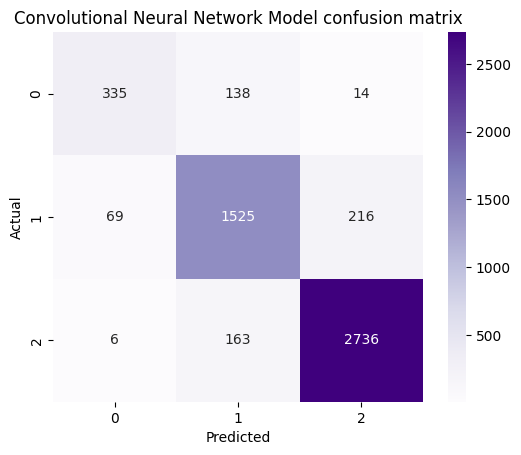

<Figure size 640x480 with 0 Axes>

Accuracy: 0.8835063437139562
F1-Score: 0.8392689811782966
Precison: 0.8582288239906593
Recall: 0.8240836291168834


In [90]:
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix 
import seaborn as sns

ax = plt.axes()
sns.heatmap(cm,ax=ax,annot=True,fmt='g',cmap='Purples',square=True)
fig = plt.figure()
fig.patch.set_facecolor('xkcd:grey')
ax.set_title('Convolutional Neural Network Model confusion matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()
print(f'Accuracy: {acc}\nF1-Score: {f1}')
print(f'Precison: {precision}\nRecall: {recall}')

In [43]:
print(mlb.classes_)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

['negative' 'neutral' 'positive']
(12135, 100) (12135,) (5202, 100) (5202,)


In [79]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Flatten
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.utils import to_categorical

# Reshape the input data to match the expected shape of the model
trainXreshaped = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
testXreshaped = np.reshape(testX, (testX.shape[0], testX.shape[1]))

# Convert ground truth labels to categorical
trainYcat = to_categorical(trainY, 3)
testYcat = to_categorical(testY, 3)

In [81]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, GlobalMaxPooling1D

# Define the architecture of the fully connected neural network (FCNN)
FCNNmodel = Sequential()
FCNNmodel.add(Embedding(input_dim=vocab, output_dim=emb_dim, input_length=max_len))
FCNNmodel.add(GlobalMaxPooling1D())
FCNNmodel.add(Dense(64, activation='relu'))
FCNNmodel.add(Dropout(0.3))
FCNNmodel.add(Dense(3, activation='softmax'))

In [82]:
#compiling my FCNN model 
FCNNmodel.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
FCNNmodel.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 100)          841300    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_25 (Dense)            (None, 64)                6464      
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 3)                 195       
                                                                 
Total params: 847,959
Trainable params: 847,959
Non-trainable params: 0
_______________________________________________

In [83]:

# Train the FCNN model
FCNNmodel.fit(trainXreshaped, trainYcat, batch_size=32, epochs=10, verbose=1)



Epoch 1/10
380/380 [==============================] - 5s 13ms/step - loss: 0.6947 - accuracy: 0.7058
Epoch 2/10
380/380 [==============================] - 5s 12ms/step - loss: 0.4148 - accuracy: 0.8254
Epoch 3/10
380/380 [==============================] - 5s 12ms/step - loss: 0.3010 - accuracy: 0.8830
Epoch 4/10
380/380 [==============================] - 5s 12ms/step - loss: 0.2195 - accuracy: 0.9186
Epoch 5/10
380/380 [==============================] - 7s 18ms/step - loss: 0.1590 - accuracy: 0.9451
Epoch 6/10
380/380 [==============================] - 6s 15ms/step - loss: 0.1086 - accuracy: 0.9652
Epoch 7/10
380/380 [==============================] - 7s 18ms/step - loss: 0.0740 - accuracy: 0.9792
Epoch 8/10
380/380 [==============================] - 7s 18ms/step - loss: 0.0489 - accuracy: 0.9867
Epoch 9/10
380/380 [==============================] - 6s 17ms/step - loss: 0.0298 - accuracy: 0.9941
Epoch 10/10
380/380 [==============================] - 7s 18ms/step - loss: 0.0194 - accura

In [84]:
# Test the model
prediction2 = FCNNmodel.predict(testX)

163/163 [==============================] - 1s 3ms/step


In [85]:
prediction2 = [np.argmax(i) for i in prediction2]
ground_truth = [np.argmax(i) for i in testY2]

In [86]:
# Calculate performance metrics and generate confusion matrix
acc2 = accuracy_score(ground_truth,prediction2)
f12 = f1_score(ground_truth,prediction2,average='macro')
cm2 = confusion_matrix(ground_truth,prediction2)
print(f'Accuracy: {acc2}\nF1-Score: {f12}')

precision2 = precision_score(ground_truth, prediction2, average='macro')
recall2 = recall_score(ground_truth, prediction2, average='macro')
print(f'Precison: {precision2}\nRecall: {recall2}')


Accuracy: 0.881199538638985
F1-Score: 0.8270532304417005
Precison: 0.847880506703519
Recall: 0.8106166445409823


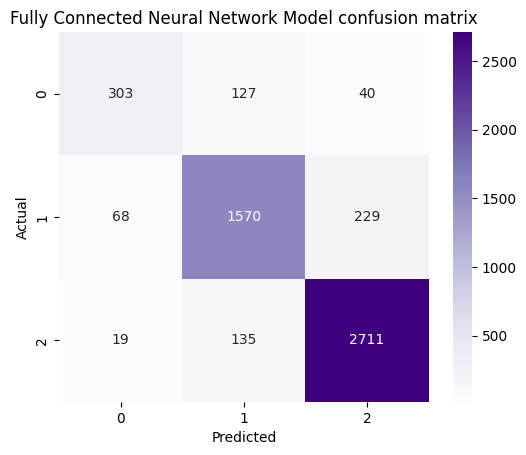

<Figure size 640x480 with 0 Axes>

Accuracy: 0.881199538638985
F1-Score: 0.8270532304417005
Precison: 0.847880506703519
Recall: 0.8106166445409823


In [88]:
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix 
import seaborn as sns


ax = plt.axes()
sns.heatmap(cm2,ax=ax,annot=True,fmt='g',cmap='Purples',square=True)
fig = plt.figure()
fig.patch.set_facecolor('xkcd:grey')
ax.set_title('Fully Connected Neural Network Model confusion matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()
print(f'Accuracy: {acc2}\nF1-Score: {f12}')
print(f'Precison: {precision2}\nRecall: {recall2}')
